In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import ipywidgets

%matplotlib inline

## 전처리
### step 1: Image frame 단위 raw 데이터 로딩 및 중간 단계 dataset file 생성
* inputs:
    * 태깅파일: ~_interpolation.json
    * 이미지파일: ~KM_0000000000.jpg
    * 감정종류: 8가지 ('happiness', 'afraid', 'neutral', 'surprise', 'sadness', 'contempt', 'anger', 'disgust')
        * 예시: {'happiness': 0, 'afraid': 0, 'neutral': 10, 'surprise': 0, 'sadness': 0, 'contempt': 0, 'anger': 0, 'disgust': 0} 일 경우 'neutral'이 선정
* 중간단계 CSV dataset file 생성
    * 태깅데이터에서 전안 얼굴 검출 되는 이미지만 추출

In [22]:
# 중단 단계 dataset file 결과 예시
# raw_tag_info = pd.read_csv('../datasets/kor_multi_modal/prep_part1_frontal_face.csv')
# raw_tag_info.head(5)

,emotion,face_rect,img_path
0,neutral,"{'max_y': 809, 'max_x': 1137, 'min_x': 720, 'm...",/tf/notebooks/datasets/emotion/multi-modal/par...
1,neutral,"{'max_y': 809, 'max_x': 1137, 'min_x': 720, 'm...",/tf/notebooks/datasets/emotion/multi-modal/par...
2,neutral,"{'max_y': 809, 'max_x': 1138, 'min_x': 721, 'm...",/tf/notebooks/datasets/emotion/multi-modal/par...
3,neutral,"{'max_y': 810, 'max_x': 1138, 'min_x': 721, 'm...",/tf/notebooks/datasets/emotion/multi-modal/par...
4,neutral,"{'max_y': 810, 'max_x': 1138, 'min_x': 721, 'm...",/tf/notebooks/datasets/emotion/multi-modal/par...


### step 2: emotion class 조정 및 최종 dataset file 생성
* emotion class 조정
    * emotion mapping
        * ASIS: 8 Catogory ('happiness', 'afraid', 'neutral', 'surprise', 'sadness', 'contempt', 'anger', 'disgust')
        * TO: 7 Category  (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)
        * mapped Category: 0=anger, 1=disgust&contempt, 2=afraid, 3=happiness, 4=sadness, 5=surprise, 6=neutral
* 최종 CSV dataset file 생성
    * 태깅데이터에서 얼굴 검출 되는 이미지만 추출    

In [24]:
# 최종 dataset file 예시: emotion, pixels 항목만 사용
# df = pd.read_csv('../datasets/kor_multi_modal/prep_col_all_mdf_frontal_face.csv')
# df.head(5)

,emotion,pixels,Usage
0,2,99 96 102 94 94 92 96 101 100 96 91 95 77 70 8...,NaN
1,2,13 15 15 15 17 16 17 16 14 14 14 15 17 20 22 2...,NaN
2,2,41 37 37 38 45 47 41 39 46 35 31 34 36 41 43 3...,NaN
3,2,20 22 19 19 19 19 20 20 20 20 21 27 30 34 35 3...,NaN
4,2,15 15 15 16 16 16 17 19 20 21 22 23 24 23 23 2...,NaN


## Model
    1. face detection
    2. emotion detection
    3. tflite 변환 테스팅
    
### 1. face detection

* OpenCV Haar cascade 방식
    * 사용이유: CPU 상 검출 시간이 빠르고, 적용하기 용이함
    * 버전: haarcascade_frontalface_alt2
    * 설명 내용 출처: https://thebook.io/006939/ch13/02/
![](https://thebook.io/img/006939/p412.jpg)
     캐스케이드 구조 1단계에서는 얼굴 검출에 가장 유용한 유사-하르 필터 하나를 사용하여, 얼굴이 아니라고 판단되면 이후의 유사-하르 필터 계산은 수행하지 않습니다. 1단계를 통과하면 2단계에서 유사-하르 필터 다섯 개를 사용하여 얼굴이 아닌지를 검사하고, 얼굴이 아니라고 판단되면 이후 단계의 검사는 수행하지 않습니다.
<img src='https://thebook.io/img/006939/p411.jpg' width=300 />
<center>얼굴 검출에 유용한 유사-하르 필터의 예</center>

* Dlib HOG(Histogram of Oriented Gradients) based 방식
    * 사용이유: CPU 상 OpenCV Haar cascade 방식보다 성능이 좋음, 적용하기 용이
    * 설명 내용 출처: https://medium.com/@jongdae.lim/기계-학습-machine-learning-은-즐겁다-part-4-63ed781eee3c
    * 검출방식 비교: https://seongkyun.github.io/study/2019/03/25/face_detection/

<img src='https://miro.medium.com/max/1022/1*dP0Ixs4vHGUKCScufH9_Vw.jpeg' width=300 />
<center>1) 이미지를 흑백으로 변환</center>
<img src='https://miro.medium.com/max/1600/1*lsNRg_1oOELFcug_AjlkqQ.gif' width=300 />
<center>2) 이미지를 16x16 픽셀의 작은 정사각형들로 분해 한 후 각 정사각형에서, 그래디언트가 주요 방향(윗쪽, 우상쪽, 오른쪽, 등)을 얼마나 가리키고 있는지 카운팅합니다.</center>
<center>그런 다음 이 사각형을 가장 강한 화살표 방향을 나타내는 벡터로 변환 합니다.</center>
<img src='https://miro.medium.com/max/1600/1*HtgQZ4guaIo8wflbsR1MLw.png' width=500 />

### 2. emotion detection
* mini_XCEPTION 모델
* 사용이유: 인식시간이 빠르고, 모델이 가볍기에 온디바이스에 적용가능
* 학습내용:
    * 학습데이터: AIhub 멀티모달 데이터(http://www.aihub.or.kr/content/555)로 학습
        * 클래스 밸런싱된 48 x 48 gray scale image 128,499만여개에서 샘플링하여 사용
    * 학습된 모델을 tflite로 변환
* 모델출처: https://arxiv.org/abs/1710.07557

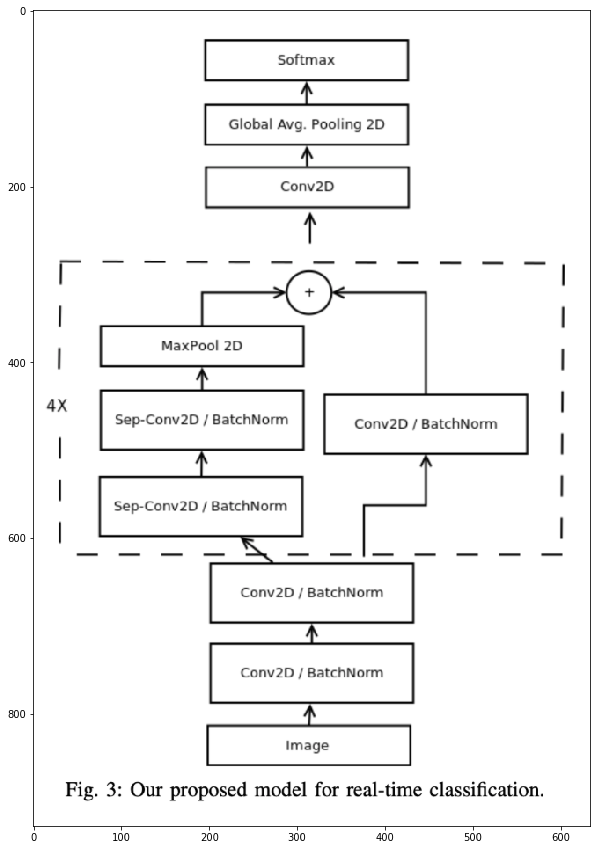

In [3]:
fig = plt.figure(figsize=(15, 15))
plt.imshow(plt.imread('../images/simple_model_structure.png'))

## 전처리
### step 1: Image frame 단위 raw 데이터 로딩 및 중간 단계 dataset file 생성

In [ ]:
# 한 파일당 약 2~3시간 소요
# python preprocess_jj.py <file_number> <input_folder> <output_folder>
예시: !python pretrain_jj.py 1 /tf/notebooks/datasets/emotion/multi-modal ../datasets/kor_multi_modal

In [8]:
!cat pretrain_jj.py

import sys
import os
import json
import io
import numpy as np
import operator
import collections
import base64
import pandas as pd
from glob import glob
from IPython.display import HTML
import ray
import matplotlib.pyplot as plt
import dlib

import logging

import cv2
from utils.inference import load_image
from utils.inference import load_detection_model
from utils.inference import detect_faces
from utils.inference import apply_offsets

emotion_offsets = (20, 40)
emotion_offsets = (0, 0)

detection_model_path = '../trained_models/detection_models/haarcascade_frontalface_alt2.xml'

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

# multi-modal 데이터셋 다운로드 위치 입력

# 입력 zip파일의 part 번호
part_num = sys.argv[1]

# input 폴더
base_folder = os.path.join(sys.argv[2],'part'+part_num+'/')

# output 파일경로
prep_trainset_frontal_face_path=os.path.join(sys.argv[3], 'prep_part'+part_num+'_frontal_face.csv')

ray.init()
face_detect = dlib.get_frontal_face_detector()

# 맵핑
def get_tagging_info(json

In [13]:
# 중단 단계 dataset file 결과 예시
raw_tag_info = pd.read_csv('../datasets/kor_multi_modal/prep_part1_frontal_face.csv')
raw_tag_info.head(5)

,emotion,face_rect,img_path
0,neutral,"{'max_y': 809, 'max_x': 1137, 'min_x': 720, 'm...",/tf/notebooks/datasets/emotion/multi-modal/par...
1,neutral,"{'max_y': 809, 'max_x': 1137, 'min_x': 720, 'm...",/tf/notebooks/datasets/emotion/multi-modal/par...
2,neutral,"{'max_y': 809, 'max_x': 1138, 'min_x': 721, 'm...",/tf/notebooks/datasets/emotion/multi-modal/par...
3,neutral,"{'max_y': 810, 'max_x': 1138, 'min_x': 721, 'm...",/tf/notebooks/datasets/emotion/multi-modal/par...
4,neutral,"{'max_y': 810, 'max_x': 1138, 'min_x': 721, 'm...",/tf/notebooks/datasets/emotion/multi-modal/par...


### step 2: emotion class 조정

In [ ]:
import os
import json
import io
import numpy as np
import operator
import collections
import base64
import pandas as pd
from glob import glob
from IPython.display import HTML
import ray
import matplotlib.pyplot as plt
import copy

import logging

import cv2
from utils.inference import load_detection_model
from utils.inference import detect_faces
from utils.inference import apply_offsets

detection_model_path = '../trained_models/detection_models/haarcascade_frontalface_alt2.xml'

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

# multi-modal 데이터셋 zip파일의 part 번호 (1~5)
part_num = '1'

# input 폴더
base_folder = '/tf/notebooks/datasets/emotion/multi-modal/part'+part_num+'/'

# output 파일경로
prep_trainset_path='../datasets/kor_multi_modal/prep_part'+part_num+'.csv'
prep_trainset_frontal_face_path='../datasets/kor_multi_modal/prep_part'+part_num+'_frontal_face.csv'
prep_trainset_mid_path='../datasets/kor_multi_modal/prep_part'+part_num+'_mid.csv'

%matplotlib inline

In [ ]:
raw_tag_info = pd.read_csv(prep_trainset_frontal_face_path)
raw_tag_info_df = pd.DataFrame(raw_tag_info)

# raw_tag_info_df["emotion"].value_counts().plot.bar()
# raw_tag_info_df["emotion"].value_counts()

## disgust와 contempt는 disgust 하나로 합침
raw_tag_info_df = raw_tag_info_df.replace('contempt', 'disgust')

## balancing sampling
min_emotion_cnt = np.min(raw_tag_info_df["emotion"].value_counts())
sampled_tag_info_df = raw_tag_info_df.groupby("emotion", group_keys=False).apply(lambda df: df.sample(min_emotion_cnt))
sampled_tag_info_df = sampled_tag_info_df.reset_index(drop=True)

# sampled_tag_info_df["emotion"].value_counts()

# sampled_tag_info_df.count()

# sampled_tag_info_df.head()

### Real-time Convolutional Neural Networks for Emotion and Gender Classification 모델을 위한 전처리 부분
import cv2
import re
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import json
import multiprocessing

# num_cores = multiprocessing.cpu_count()
num_cores = 5

def img_path_to_pixel(x):
    
    img_path, face_rect = x[0], x[1]
    face_rect = json.loads(face_rect.replace("'", "\""))
    
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_shape = img.shape
    
    # face_rect 부분 잘라내기
    # ex) 'max_x': 1125, 'max_y': 798, 'min_x': 708, 'min_y': 267
    min_x = face_rect['min_x']
    max_x = face_rect['max_x']
    min_y = face_rect['min_y']
    max_y = face_rect['max_y']
    
    if  not isinstance(min_x, int) or not isinstance(max_x, int) or  not isinstance(min_y, int) or not isinstance(max_y, int) or \
        min_x <= 0 or max_x <= 0 or min_y <= 0 or max_y <= 0:
        return None
    
#     print(min_y,max_y, min_x,max_x)
    img = img[min_y:max_y, min_x:max_x]
    
    # 이미지 축소 시에는 INTER_AREA, https://076923.github.io/posts/Python-opencv-8/
    img = cv2.resize(img, dsize=(48, 48), interpolation=cv2.INTER_AREA)
    
    # split array to ' ' str
    img = ' '.join(img.astype(int).astype(str).reshape(-1))
    
    return img

def multi_process_sub(df_split):

    return df_split[['img_path', 'face_rect']].apply(img_path_to_pixel, axis=1)

def multi_process(df, func):
    df_split = np.array_split(df, num_cores)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

# %time sampled_tag_info_df['img_path_new'] = sampled_tag_info_df[['img_path','face_rect']].apply(img_path_to_pixel, axis=1)

%time sampled_tag_info_df['img_path_new'] = multi_process(sampled_tag_info_df, multi_process_sub)

# sampled_tag_info_df.shape

# 이상 데이터 drop
sampled_tag_info_df = sampled_tag_info_df.dropna().reset_index(drop=True)

# sampled_tag_info_df.shape

sampled_tag_info_df['img_path'] = sampled_tag_info_df['img_path_new']
prep_tag_info_df = sampled_tag_info_df.drop(['img_path_new', 'face_rect'], axis=1)

# prep_tag_info_df["emotion"].value_counts().plot.bar()

# * CSV dataset file 생성
#     * 포멧: emotion
#     * emotion mapping
#         * ASIS: 8 Catogory ('happiness', 'afraid', 'neutral', 'surprise', 'sadness', 'contempt', 'anger', 'disgust')
#         * TO: 7 Category  (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)
#         * mapped Category: 0=anger, 1=disgust&contempt, 2=afraid, 3=happiness, 4=sadness, 5=surprise, 6=neutral

def emotion_mapping(emotion):
    if emotion == 'anger':
        return 0
    elif emotion == 'disgust' or emotion == 'contempt':
        return 1
    elif emotion == 'afraid':
        return 2
    elif emotion == 'happiness':
        return 3
    elif emotion == 'sadness':
        return 4
    elif emotion == 'surprise':
        return 5
    elif emotion == 'neutral':
        return 6
    else:
        return 6
        

prep_tag_info_df['mapped_emotion'] = prep_tag_info_df['emotion'].map(emotion_mapping)

# prep_tag_info_df['mapped_emotion'].value_counts()

prep_tag_info_df['emotion'] = prep_tag_info_df['mapped_emotion']
prep_tag_info_df = prep_tag_info_df.drop(['mapped_emotion'], axis=1)
# prep_tag_info_df.head()

prep_tag_info_df.to_csv(prep_trainset_mid_path, index=False)

tmp_df = pd.read_csv(prep_trainset_mid_path)

tmp_df.head()

In [14]:
# 최종 dataset file 예시: emotion, pixels 항목만 사용
df = pd.read_csv('../datasets/kor_multi_modal/prep_col_all_mdf_frontal_face.csv')
df.head(5)

,emotion,pixels,Usage
0,2,99 96 102 94 94 92 96 101 100 96 91 95 77 70 8...,NaN
1,2,13 15 15 15 17 16 17 16 14 14 14 15 17 20 22 2...,NaN
2,2,41 37 37 38 45 47 41 39 46 35 31 34 36 41 43 3...,NaN
3,2,20 22 19 19 19 19 20 20 20 20 21 27 30 34 35 3...,NaN
4,2,15 15 15 16 16 16 17 19 20 21 22 23 24 23 23 2...,NaN


## 모델
### 1. face detection

In [ ]:
model_path = '../trained_models/detection_models/haarcascade_frontalface_alt2.xml'
detection_model = cv2.CascadeClassifier(model_path)

### 2. emotion detection

In [ ]:
# 추후 공개

### 3. TFlite 모델 파일 테스팅

In [10]:
!ls models/

__init__.py  __pycache__  cnn.py


In [5]:
demo_df = pd.read_csv("../data/demo.csv")

In [6]:
%%time
def f(x):
    emotion_map = {
        0:'anger'
        ,1:'disgust, contempt'
        ,2:'afraid'
        ,3:'happiness'
        ,4:'sadness'
        ,5:'surprise'
        ,6:'neutral'
    }
    row = demo_df.iloc[x]
    pixels = row['pixels']
    emotion = row['emotion']
    img = np.asarray(pixels.split(" "), dtype=np.int16).reshape((48, 48))
    img = img / 255.0
    input_data = tf.cast(img, tf.float32)
    input_data = input_data[tf.newaxis,:,:,tf.newaxis]

    fig = plt.figure(figsize=(10, 10))
    fig.add_subplot(2, 1, 1)
    print('Label: ', emotion_map[emotion], plt.imshow(img, 'gray'))

    # Load TFLite model and allocate tensors.
    interpreter = tf.lite.Interpreter(model_path="../models/converted_model_final.tflite")
    interpreter.allocate_tensors()

    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Test model on random input data.
    input_shape = input_details[0]['shape']
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()

    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    output_data = interpreter.get_tensor(output_details[0]['index'])
    print('Predicted label: ', emotion_map[np.argmax(output_data)], output_data)
    fig.add_subplot(2, 1, 2)
    plt.bar(emotion_map.values(), output_data[0]*100)
    
ipywidgets.interactive(f, x = ipywidgets.IntSlider(0, 0, demo_df.shape[0]-1, 1))

CPU times: user 16.4 ms, sys: 3.17 ms, total: 19.6 ms
Wall time: 18.7 ms


interactive(children=(IntSlider(value=0, description='x', max=25), Output()), _dom_classes=('widget-interact',…